In [6]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import statistics
import sys

from statsmodels.formula.api import ols

import scipy.cluster.hierarchy as scipy_hierarchy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import linregress

In [7]:
# GENERAL CONFIGURATION FOR THE ANALYSIS:
# Adjacency type affects how the adjacency matrix is calculated. The signed method, im not sure if it makes sense
adjacency_type = "unsigned"

In [8]:
# SETTINGS FOR PLOTTING FIGURES
PLOTS_WANTED = True
dpi_general = 500

# Settings for printing dataframes
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

In [9]:
# Colors for the terminal outputs
ENDC = "\033[0m"
BOLD = "\033[1m"
UNDERLINE = "\033[4m"

OKBLUE = "\033[94m"
OKGREEN = "\033[92m"
WARNING = "\033[93m"
FAIL = "\033[91m"

In [10]:
## Move out of the notebook folder to access datasets
working_dir = os.getcwd()
working_dir = working_dir.strip('notebooks')



## Load the dataset
# Transcriptomics Data - We assume a dataset structure were col are the genes, and rows are the samples
transcriptomics_dataset_dir = working_dir + 'data/5xFAD_paper/expressionList.csv'  
transcriptomics_dataset = pd.read_csv(transcriptomics_dataset_dir, index_col=0)

# Sample info and Clinical Traits Data
sample_info_selection_dir = working_dir + 'data/5xFAD_paper/sampleInfo.csv'
sample_info_selection = pd.read_csv(sample_info_selection_dir)

# Figures Saving output dir
figures_dir = working_dir + 'results/WGCNA_figures_own/'

# Check if the directory exists, and if not, create it
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"{BOLD}{OKBLUE}Creating directory to save results and figures...{ENDC}")



## Make a subset to save RAM
subset_dataset_size = 100
transcriptomics_dataset = transcriptomics_dataset.iloc[:, :subset_dataset_size] 

# RAM usage estimation in GB
RAM_estimate = (subset_dataset_size * subset_dataset_size * 8) / (1024**3)
print(f"The aproximated RAM to analyse this size of dataset is: {RAM_estimate} GB")


The aproximated RAM to analyse this size of dataset is: 7.450580596923828e-05 GB


In [11]:
### Step 1: Data Preprocessing (Normalization)
## Preprocessing: removing obvious outlier on genes and samples
print(f"{BOLD}{OKBLUE}Pre-processing...{ENDC}")



## Prepare and clean data
# Remove genes expressed under this cutoff number along samples - use clustering of samples



## Remove genes with no variation across samples (0 vectors) 
# Also print how many genes have been removed in this steo
num_genes_before = transcriptomics_dataset.shape[1]
transcriptomics_dataset = transcriptomics_dataset.loc[:, (transcriptomics_dataset != 0).any(axis=0)] # Actually droping columns with 0 variation

num_genes_removed = num_genes_before - transcriptomics_dataset.shape[1]
print(f"{BOLD}{WARNING}{num_genes_removed} genes were removed due to having 0 variation across samples...{ENDC}")



# NOTES: Maybe no onlyt genes with no variation, but small variation.




transcriptomics_dataset_filtered = transcriptomics_dataset
print(f"{BOLD}{OKBLUE}Done...{ENDC}")

Pre-processing...
2 genes were removed due to having 0 variation across samples...
Done...


Calculating Correlation Matrix...
Plotting and Saving the Correlation Matrix...


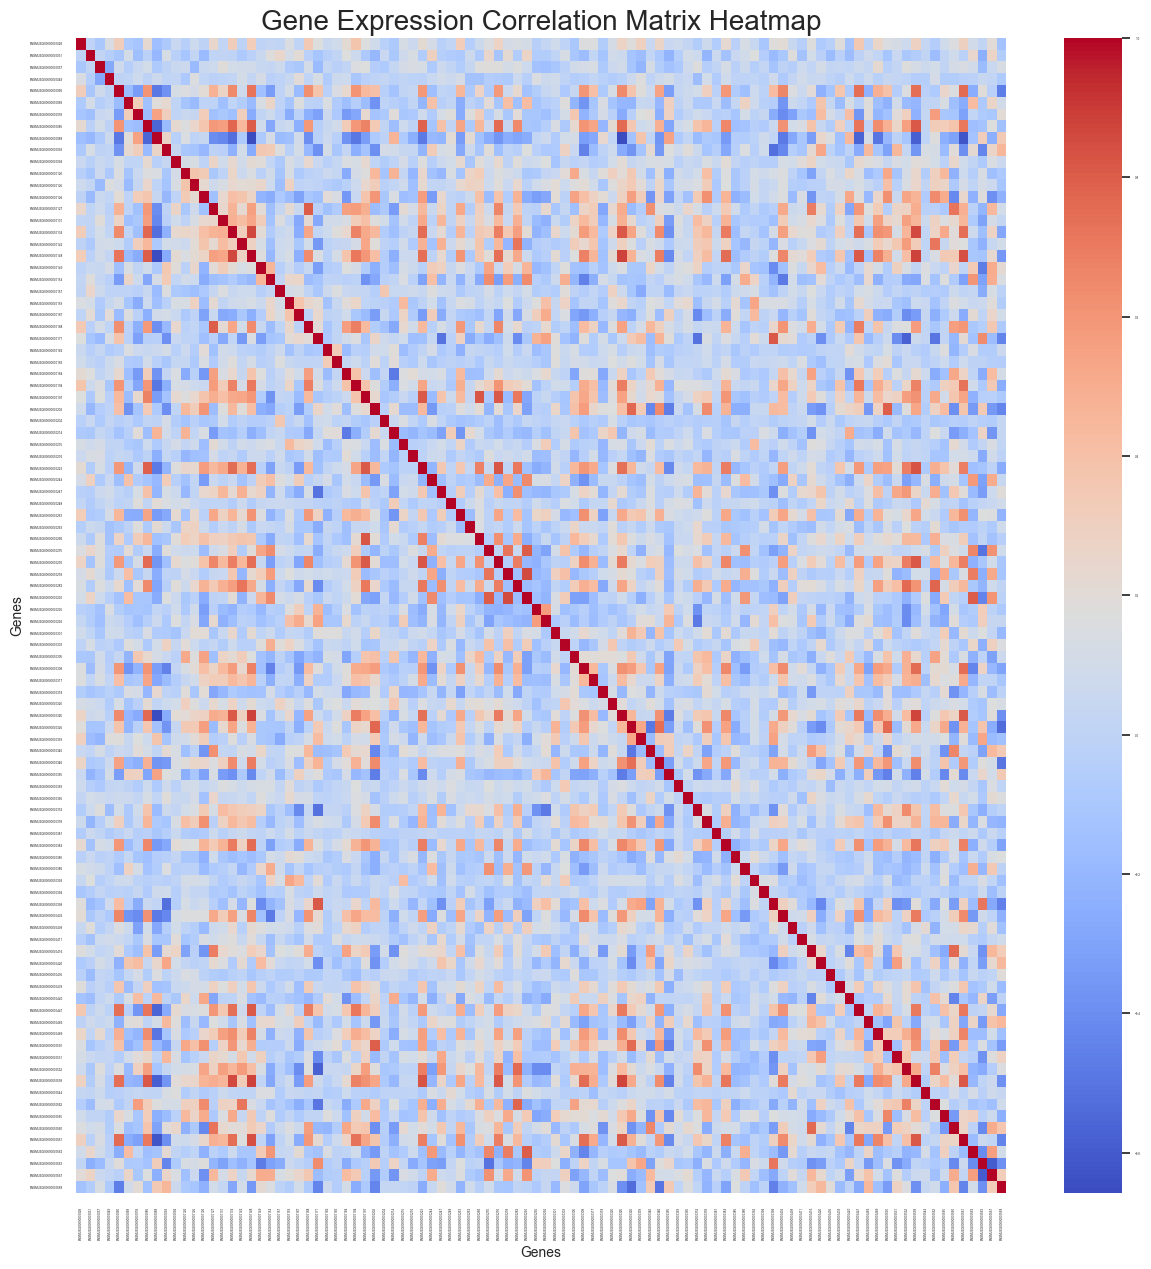

Done


In [12]:
### Step 2: Constructing a Co-expression Similarity Matrix (Correlation Matrix)
print(f"{BOLD}{OKBLUE}Calculating Correlation Matrix...{ENDC}")



## Calculate the correlation matrix using Pearson correlation
correlation_matrix = transcriptomics_dataset_filtered.corr(method='pearson')



## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Correlation Matrix...{ENDC}")
    title_figure = 'Gene Expression Correlation Matrix Heatmap'

    plt.figure(figsize=(15, 15))
    sns.set(font_scale=0.2)
    sns.heatmap(correlation_matrix, cmap='coolwarm', xticklabels=True, yticklabels=True)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    sns.set(font_scale=1)

print(f"{BOLD}{OKBLUE}Done{ENDC}")

Transforming Correlation Matrix into Adjacency Matrix...
Starting Soft Power-Thresholding algorithmic search ...
   Power  SFT.R.sq  slope.SFT  truncatedExponentialAdjRsquared  mean(connectivity)  median(connectivity)  max(connectivity)
1      1  0.002155  -0.039377                        -0.074335           16.840528             16.782051          29.780858
2      2  0.621627  -0.699048                         0.649639            5.574921              5.115288          15.574221
3      3  0.732426  -0.904384                         0.761264            2.557434              1.808324           9.909277
4      4  0.209735  -3.339620                         0.059657            1.403808              0.755913           6.915584
5      5  0.204112  -2.394437                         0.072145            0.857721              0.359521           5.088799
6      6  0.192275  -2.914565                        -0.000546            0.562003              0.170496           3.876492
7      7  0.215404 

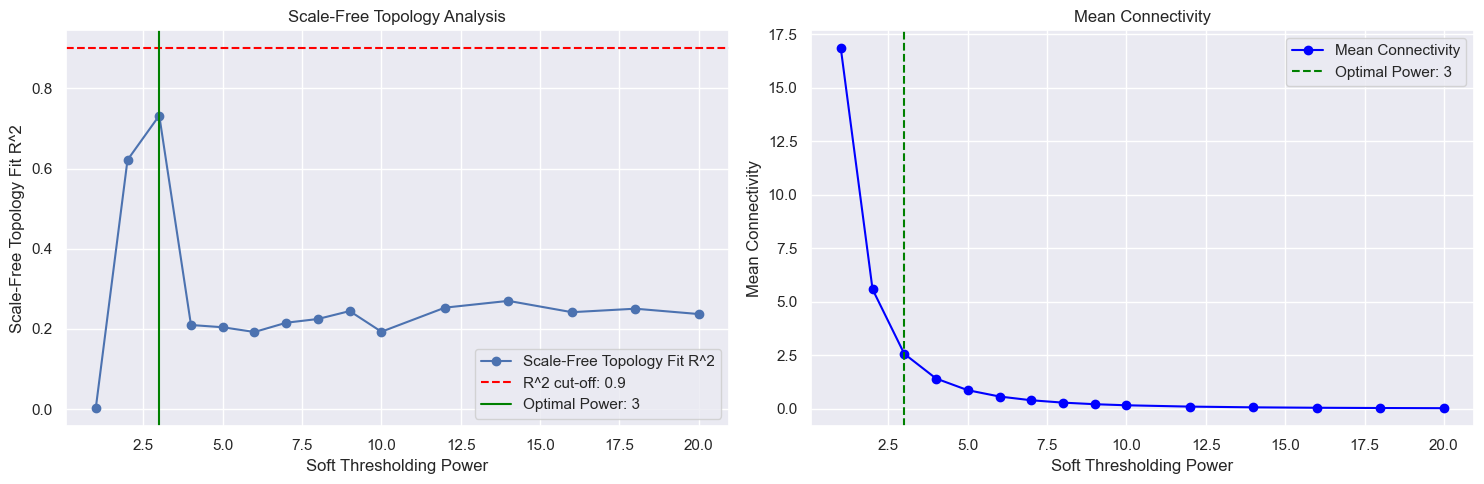

Done


Calculating Adjacency Matrix...
Done


Plotting and Saving the Adjacency Matrix...


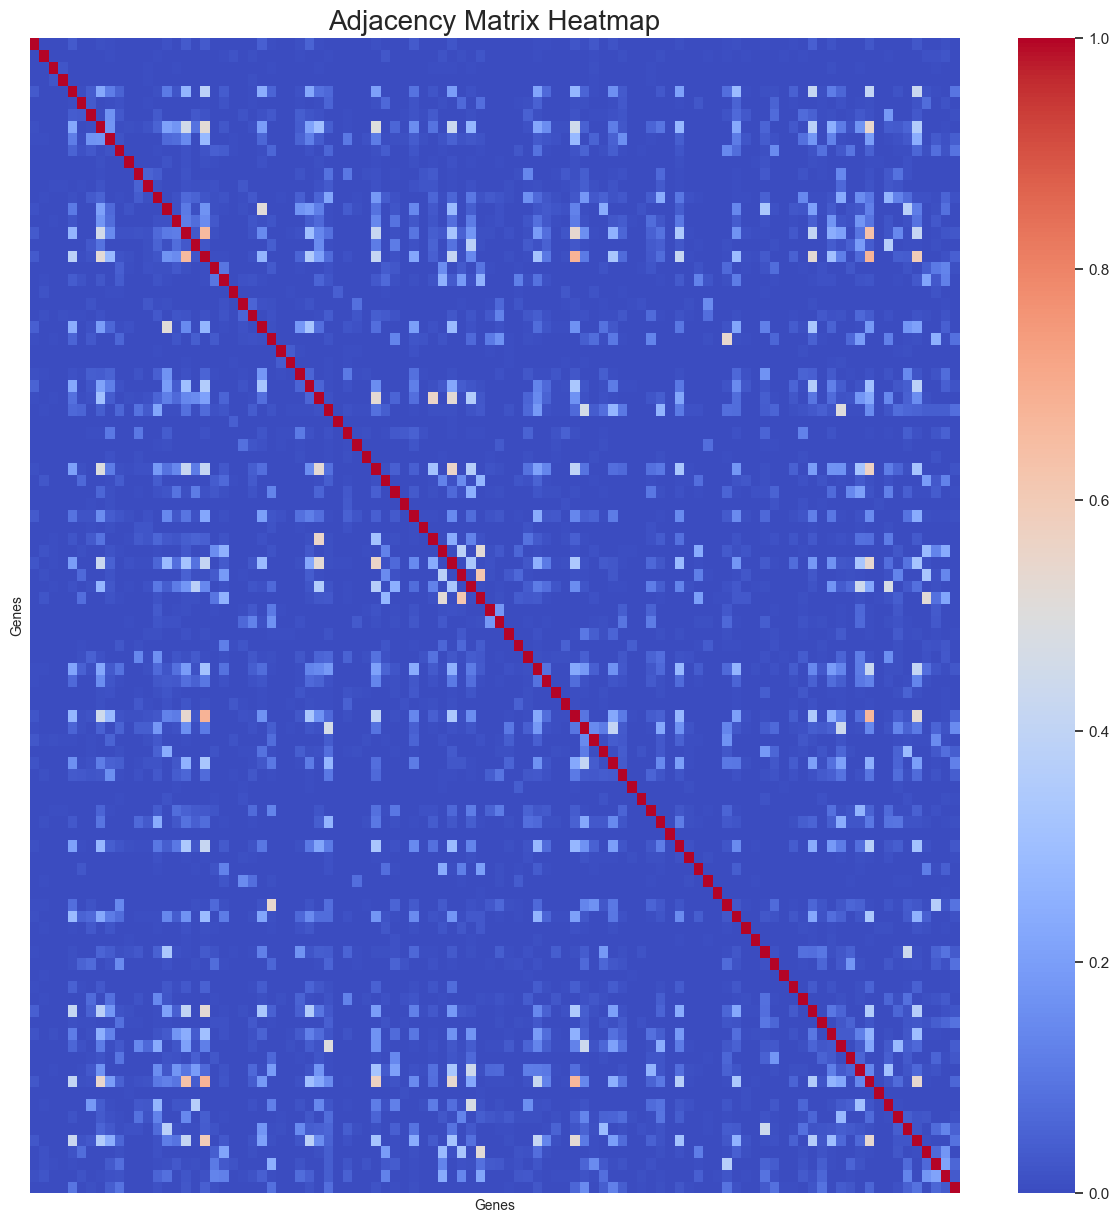

Done


In [13]:
### Step 3: Transforming into an adjacency matrix using a soft threshold power β
print(f"{BOLD}{OKBLUE}Transforming Correlation Matrix into Adjacency Matrix...{ENDC}")



####################################### FUNCTIONS #######################################

### Function that checks if the adjacency matrix resembles a scale-free network topology (following a power-law distribution).
def scaleFreeFitIndex(connectivity, block_size=10):  # values and code highly taken from pyWGCNA, only small adaptations
    """
    Calculates several fitting statistics to evaluate scale free topology fit.


    block_size = Size of the blocks in which the connectivity is discretized
    """
    

    # Ensure all data is non zero
    connectivity = connectivity[connectivity > 0]

    # Turn the connectivity into a dataframe, and discretize into blocks of block_size size
    connectivity = pd.DataFrame({'data': connectivity})
    connectivity['discretized_connectivity'] = pd.cut(connectivity['data'], block_size)

    # Calculate mean connectivity, probability density for each block
    '''
    mean_connectivity_per_block = connectivity.groupby('discretized_connectivity')['data'].mean().reset_index(name='mean_connectivity_per_block')
    probability_density_per_block = connectivity['discretized_connectivity'].value_counts(normalize=True).reset_index(name='probability_dens_per_block')
    probability_density_per_block['discretized_connectivity'] = probability_density_per_block['index'].apply(lambda x: x.mid)
    '''
    per_block_stats = connectivity.groupby('discretized_connectivity', observed=False)['data'].agg(['mean', 'count']) \
                            .reset_index().rename(columns={'mean': 'mean_connectivity_per_block', 'count': 'count_per_block'})
    per_block_stats['probability_density_per_block'] = per_block_stats['count_per_block'] / len(connectivity)

    # Handle blocks with no values or zero connectivity
    breaks = np.linspace(start=connectivity['data'].min(), stop=connectivity['data'].max(), num=block_size + 1)
    mid_points_blocks = 0.5 * (breaks[:-1] + breaks[1:])  # Mid-points of blocks

    # Impute missing or zero dk values with bin midpoints
    for i, row in per_block_stats.iterrows():
        if pd.isnull(row['mean_connectivity_per_block']) or row['mean_connectivity_per_block'] == 0:
            per_block_stats.at[i, 'mean_connectivity_per_block'] = mid_points_blocks[i]


    # Logarithmic transformation
    per_block_stats['log_mean_conn'] = np.log10(per_block_stats['mean_connectivity_per_block'])
    per_block_stats['log_prob_distr_conn'] = np.log10(per_block_stats['probability_density_per_block'] + 1e-9)

    # Linear regression Model
    simple_linear_regression_model = ols('log_prob_distr_conn ~ log_mean_conn', data=per_block_stats).fit()
    rsquared = simple_linear_regression_model.rsquared
    slope = simple_linear_regression_model.params['log_mean_conn']
    
    # Quadratic Regression Model for Adjusted R-squared
    quadratic_regression_model = ols('log_prob_distr_conn ~ log_mean_conn + I(log_mean_conn**2)', data=per_block_stats).fit()
    rsquared_adj = quadratic_regression_model.rsquared_adj

    return pd.DataFrame({
        'Rsquared.SFT': [rsquared],
        'slope.SFT': [slope],
        'truncatedExponentialAdjRsquared': [rsquared_adj]
    })



### Function that analyses the network topology of the dataset
def pickSoftThreshold(correlation_matrix, RsquaredCut, MeanCut):
    """
    Analyzes scale-free topology for multiple soft thresholding powers.
    Soft power-thresholding is a value used to power each value of the correlation matrix of the genes to that threshold.
    The assumption is that by raising the correlation values to a power, we will reduce the noise of the correlations in
    the adjacency matrix, therefore putting in relevance important links and tuning down the noise.

    To pick up the threshold, the pickSoftThreshold function calculates for each possible power if the network resembles
    a scale-free network topology (following a power-law distribution).
    The power which produce a higher similarity with a scale-free network is the one returned.

    This is critical in WGCNA, as the premise of the method is that biological networks often exhibit scale-free properties, 
    meaning that a few nodes (genes) are highly connected, while most have few connections.

    
    RsquaredCut: Threshold for the R^2 statistic
    MeanCut: Threshold for the Mean Connectivity statistic
    """


    ## Initial checks and setup of internal variables
    correlation_matrix = correlation_matrix
    powerVector = list(range(1, 11)) + list(range(12, 21, 2))  # values taken from pyWGCNA package
    # Initialize output DataFrame
    results = pd.DataFrame(index=powerVector, columns=["Power", "SFT.R.sq"])



    ## Build and adjacency matrix with each power, and test its fit to scale-free network topology
    for power in powerVector:
        # Calculate adjacency matrix from the correlation_matrix with each power
        adjacency_matrix = np.power(np.abs(correlation_matrix), power)
        
        # Calculate connectivity for each node/gene
        connectivity = adjacency_matrix.sum(axis=0) - 1  # we remove the autocorrelation for each row
        
        # Check the resemblance to a scale-free network topology 
        fit_values = scaleFreeFitIndex(connectivity)
        
        # Store results
        results.loc[power, "Power"] = power
        results.loc[power, "SFT.R.sq"] = fit_values['Rsquared.SFT'].values[0]
        results.loc[power, "slope.SFT"] = fit_values['slope.SFT'].values[0]
        results.loc[power, "truncatedExponentialAdjRsquared"] = fit_values['truncatedExponentialAdjRsquared'].values[0]
        results.loc[power, "mean(connectivity)"] = connectivity.mean()
        results.loc[power, "median(connectivity)"] = connectivity.median()
        results.loc[power, "max(connectivity)"] = connectivity.max()
    print(results)


    ## Select the power with the best fit
    valid_powers = results[(results["SFT.R.sq"] > RsquaredCut) & (results["mean(connectivity)"] < MeanCut)]
    if not valid_powers.empty:
        optimal_power = valid_powers.index[0]
    else:
        optimal_power = results["SFT.R.sq"].idxmax()


    print(f"{BOLD}{OKGREEN}The optimal Power-Threshold found is {optimal_power}.{ENDC}")
    return optimal_power, results






## Choosing the soft-thresholding power: analysis of network topology based on the dataset
RsquaredCut = 0.9   # Values from pyWGCNA
MeanCut = 100       # Values from pyWGCNA

print(f"{BOLD}{OKBLUE}Starting Soft Power-Thresholding algorithmic search ...{ENDC}")
optimal_power, results = pickSoftThreshold(correlation_matrix, RsquaredCut, MeanCut) 
print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")

# Plotting the results
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving Scale-Free Topology fit analysis...{ENDC}")
    title_figure1 = 'Scale-Free Topology Analysis'
    title_figure2 = 'Mean Connectivity'

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting Scale-Free Topology Analysis
    axs[0].plot(results.index, results['SFT.R.sq'], marker='o', linestyle='-', label='Scale-Free Topology Fit R^2')
    axs[0].axhline(y=RsquaredCut, color='red', linestyle='--', label=f'R^2 cut-off: {RsquaredCut}')
    axs[0].axvline(x=optimal_power, color='green', linestyle='-', label=f'Optimal Power: {optimal_power}')
    axs[0].set_xlabel('Soft Thresholding Power')
    axs[0].set_ylabel('Scale-Free Topology Fit R^2')
    axs[0].set_title(title_figure1)
    axs[0].legend()

    # Plotting Mean Connectivity vs. Soft Thresholding Power
    axs[1].plot(results.index, results['mean(connectivity)'], marker='o', linestyle='-', color='blue', label='Mean Connectivity')
    axs[1].axvline(x=optimal_power, color='green', linestyle='--', label=f'Optimal Power: {optimal_power}')
    axs[1].set_xlabel('Soft Thresholding Power')
    axs[1].set_ylabel('Mean Connectivity')
    axs[1].set_title(title_figure2)
    axs[1].legend()

    plt.tight_layout()
    plt.savefig(figures_dir + title_figure1 + " and " + title_figure2, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")





## Making the adjacency  matrix out of the correlation matrix, based on the soft-thresholding power selected
print(f"{BOLD}{OKBLUE}Calculating Adjacency Matrix...{ENDC}")

adjacency_type = adjacency_type
if adjacency_type == "unsigned":
    adjacency_matrix = np.power(np.abs(correlation_matrix), optimal_power)
elif adjacency_type == 'signed':
    correlation_matrix = (correlation_matrix + 1) / 2
    adjacency_matrix = np.power(correlation_matrix, optimal_power)

print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")


## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Adjacency Matrix...{ENDC}")
    title_figure = 'Adjacency Matrix Heatmap'

    plt.figure(figsize=(15, 15))
    sns.heatmap(adjacency_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")



Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...
Calculating the TOM...
Done


Plotting and Saving the TOM...


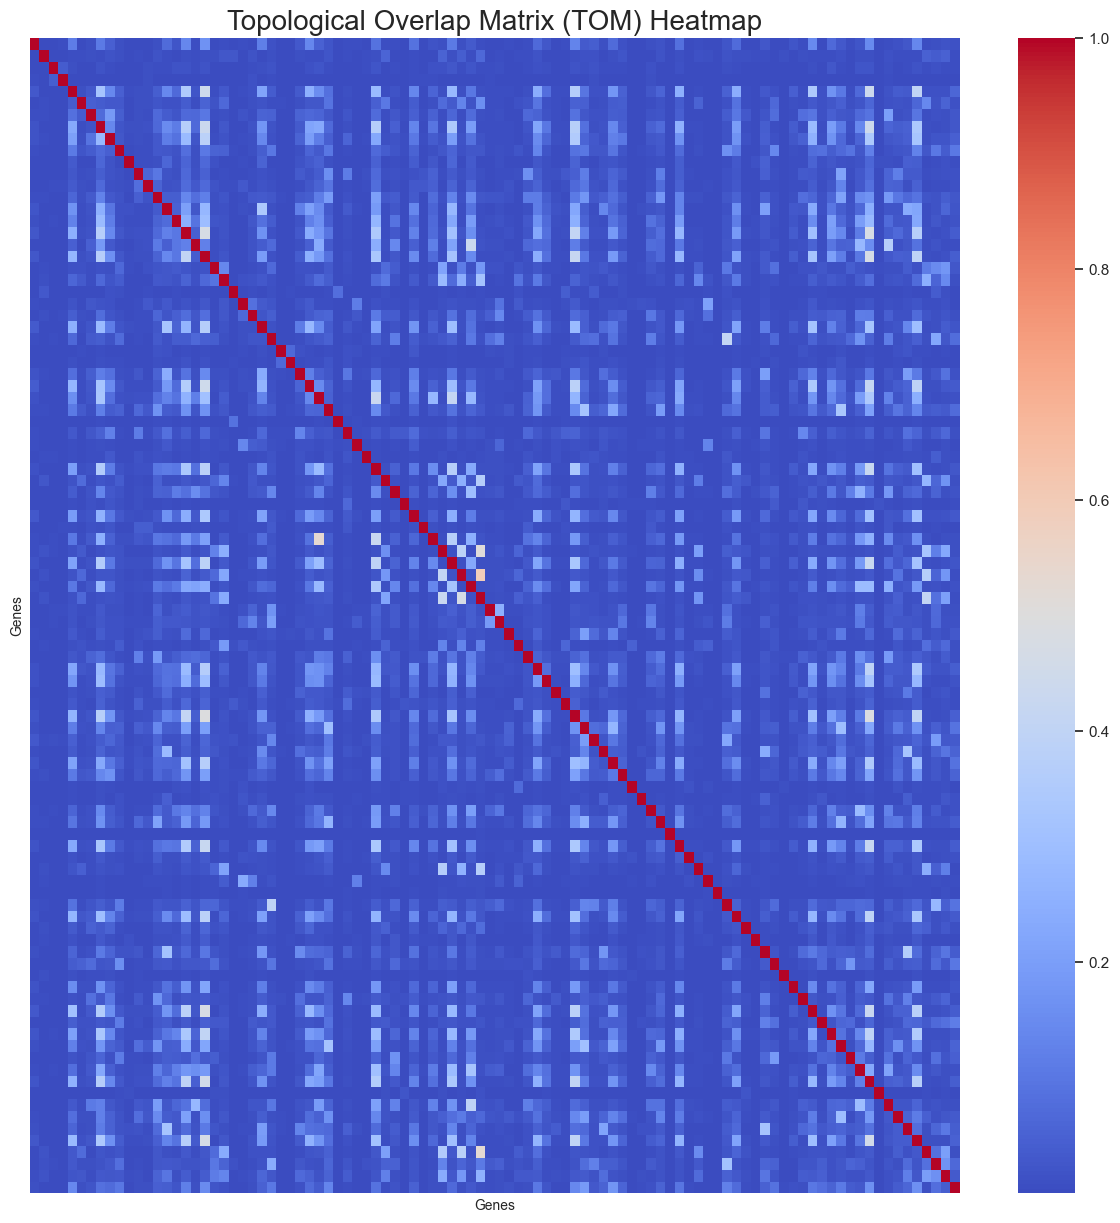

Done


In [14]:
### Step 4: Converting adjacency matrix into a topological overlap matrix (TOM)
print(f"{BOLD}{OKBLUE}Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...{ENDC}")



####################################### FUNCTIONS #######################################
def calculate_tom(adjacency_matrix, TOMDenom):
    '''
    This function takes the adjacency matrix and calculates the Topological Overlap Matrix (TOM) from it.
    This matrix is a similarity matrix, using as the similarity metric the amount of genes that two genes 
    have in common, therefore the overlap of neighbors between two genes.

    
    TOMType:  Unsigned or Signed topologies
    TOMDenom: A character string specifying the TOM variant to be used. Recognized values are "min" giving the standard TOM described 
                in Zhang and Horvath (2005), and "mean" in which the min function in the denominator is replaced by mean. The "mean" 
                may produce better results but at this time should be considered experimental.
    '''

    numeric_adjacency_matrix = adjacency_matrix.to_numpy()
    n_rows = numeric_adjacency_matrix.shape[0]

    # Calculate numerator as A^2
    numerator = np.dot(numeric_adjacency_matrix, numeric_adjacency_matrix)

    # Denominator calculation based on TOMDenom selection
    if TOMDenom == "min":
        row_sum = numeric_adjacency_matrix.sum(axis=1).reshape((n_rows, 1))
        col_sum = numeric_adjacency_matrix.sum(axis=0).reshape((1, n_rows))
        denominator = np.minimum(row_sum, col_sum.T) - numeric_adjacency_matrix
    elif TOMDenom == "mean":
        row_sum = numeric_adjacency_matrix.sum(axis=1).reshape((n_rows, 1))
        col_sum = numeric_adjacency_matrix.sum(axis=0).reshape((1, n_rows))
        denominator = (row_sum + col_sum - numeric_adjacency_matrix) / 2

    # Avoid division by zero
    denominator[denominator == 0] = np.nan

    # Calculate the TOM
    TOM = numerator / denominator

    # Set diagonal to 1 as per TOM definition
    np.fill_diagonal(TOM, 1)  

    # Handle NaN values and set them to zero
    TOM = np.nan_to_num(TOM, nan=0)

    # Convert back to DataFrame
    TOM = pd.DataFrame(TOM, index=adjacency_matrix.index, columns=adjacency_matrix.columns)

    return TOM






## Calculating the TOM from the Adjacency Matrix
# TOMDenom must be either 'min' or 'mean'. More explanation in the function itself
TOMDenom = "min"

print(f"{BOLD}{OKBLUE}Calculating the TOM...{ENDC}")
simTOM = calculate_tom(adjacency_matrix, TOMDenom)
dissTOM = 1 - simTOM

print(f"{BOLD}{OKBLUE}Done\n\n{ENDC}")



## Plotting the heatmap
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the TOM...{ENDC}")
    title_figure = 'Topological Overlap Matrix (TOM) Heatmap'

    plt.figure(figsize=(15, 15))
    sns.heatmap(simTOM, cmap='coolwarm', xticklabels=False, yticklabels=False)
    plt.title(title_figure, fontsize=20)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Genes', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")


Doing Hierarchical clustering over the dissimilarity TOM (1-TOM)...
Done...


Plotting and Saving the Dendogram from the Hierarchical clustering...


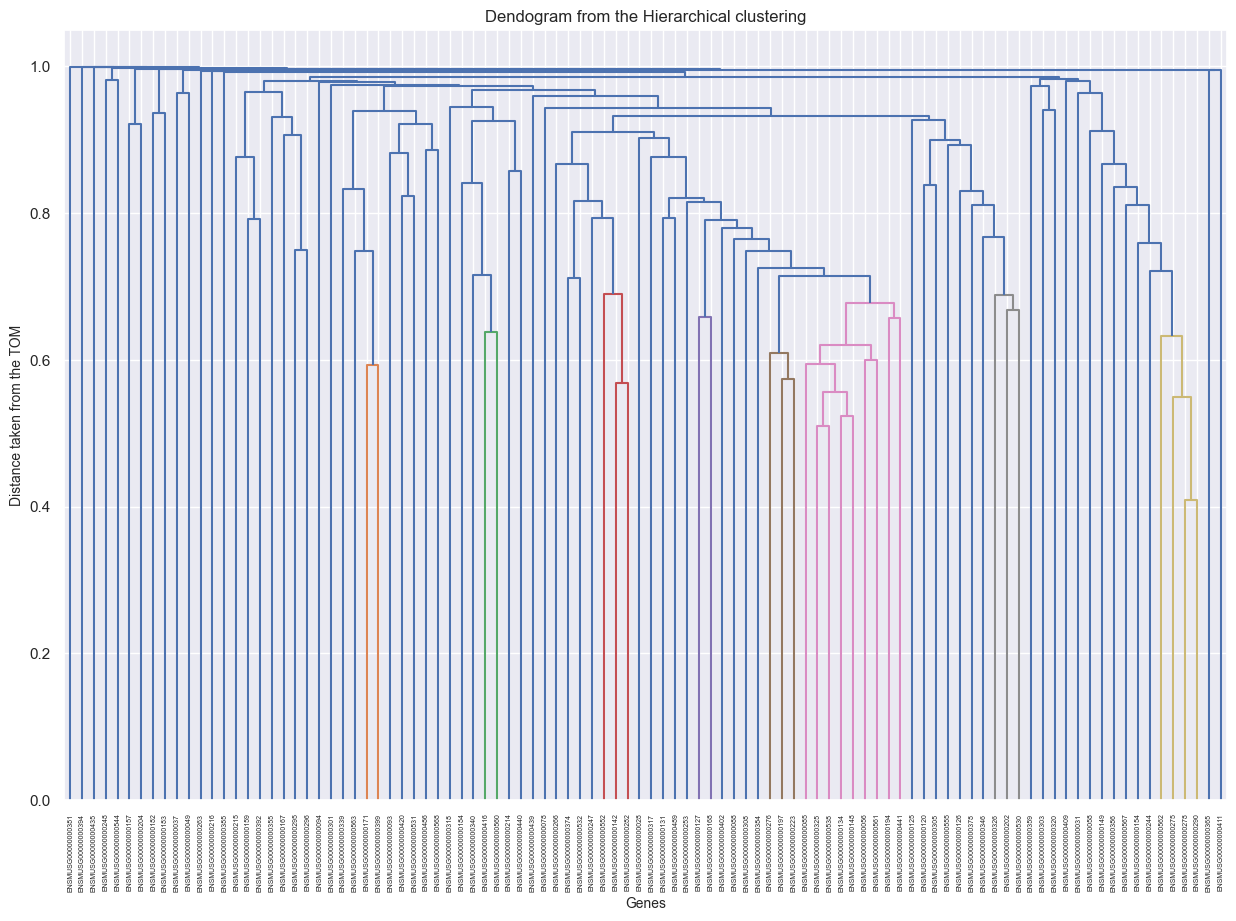

Done


In [15]:
### Step 5: Hierarchical clustering
## We use a dendogram where the distances are taken from the dissTOM 


print(f"{BOLD}{OKBLUE}Doing Hierarchical clustering over the dissimilarity TOM (1-TOM)...{ENDC}")
# Take only one half of the TOM matrix, since it is square and symmetrix
condensed_dissTOM = squareform(dissTOM.values, checks=False)

## Do the Hierarchical clustering
# The different methods can be: "single", "complete", "average", "weighted", "centroid"]
method = "average"  
linkage_matrix = scipy_hierarchy.linkage(condensed_dissTOM, method=method)
print(f"{BOLD}{OKBLUE}Done...\n\n{ENDC}")


## Plot the dendrogram
if PLOTS_WANTED:
    print(f"{BOLD}{OKBLUE}Plotting and Saving the Dendogram from the Hierarchical clustering...{ENDC}")
    title_figure = 'Dendogram from the Hierarchical clustering'

    plt.figure(figsize=(15, 10))  # Adjust the size as needed
    scipy_hierarchy.dendrogram(linkage_matrix, truncate_mode=None, labels=dissTOM.index, leaf_rotation=90)
    plt.title(title_figure)
    plt.xlabel('Genes', fontsize=10)
    plt.ylabel('Distance taken from the TOM', fontsize=10)
    plt.savefig(figures_dir + title_figure, dpi=dpi_general)
    plt.show()
    print(f"{BOLD}{OKBLUE}Done{ENDC}")

In [18]:
### Step 6: Module identification
print(f"{BOLD}{OKBLUE}Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...{ENDC}")



####################################### FUNCTIONS #######################################
def identify_modules(linkage_matrix, diss_matrix, min_memb_cluster, sensitivity):
    """
    Identify gene modules from the hierarchical clustering dendrogram.

    min_memb_cluster: Minimum number of genes in a module, for it to be a cluster.
    sensitivity: Sensitivity for module detection, higher values lead to more and smaller modules.
    """

    ## Get some basic parameters about the dendogram
    tree_height = scipy_hierarchy.to_tree(linkage_matrix, True)
    height = np.array([c.dist for c in scipy_hierarchy.clusternode[1] if c.is_leaf() is not True])



    ## Start with the merging of branches



    # Set cut_height dynamically if not specified
    max_dendro_height = np.max(linkage_matrix[:, 2])
    cut_height = max_dendro_height / sensitivity

    # Form clusters based on the parameters
    cluster_labels = scipy_hierarchy.fcluster(linkage_matrix, t=cut_height, criterion='distance')

    # Build a "dictionary" where each gene is maped to its cluster
    module_assignment = pd.DataFrame({'Gene': range(1, len(cluster_labels) + 1), 'Module': cluster_labels})

    # Apply size resctriction, keeping only bigger than min_memb_cluster cluster
    module_sizes = module_assignment['Module'].value_counts()
    valid_modules = module_sizes[module_sizes >= min_memb_cluster].index
    module_assignment = module_assignment[module_assignment['Module'].isin(valid_modules)]




def identify_modules_simple_version(linkage_matrix):
    '''
    Very Basic first approach (written out of what I know about tree cutting) to extract flat clusters (gene modules)
    out of the Dendogram, trying to make it balanced with dynamic parameters.
    '''

    
    # Dynamically set parameters based on dendrogram size
    n_genes = linkage_matrix.shape[0] + 1  # Number of genes is one more than the number of linkage steps
    min_memb_cluster = max(2, int(n_genes * 0.01))  # At least 1% of genes or at least 2
    height_percentile = 80  # Use the 80th percentile of heights to set sensitivity
    cut_height_percentile = np.percentile(linkage_matrix[:, 2], height_percentile)
    
    # Set cut_height based on dynamic sensitivity
    max_dendro_height = np.max(linkage_matrix[:, 2])
    sensitivity = max_dendro_height / cut_height_percentile
    cut_height = max_dendro_height / sensitivity

    # Form flat clusters
    cluster_labels = scipy_hierarchy.fcluster(linkage_matrix, t=cut_height, criterion='distance')

    # Map genes to their cluster labels
    module_assignment = pd.DataFrame({'Gene': range(1, len(cluster_labels) + 1), 'Module': cluster_labels})

    # Filter out small modules
    module_sizes = module_assignment['Module'].value_counts()
    valid_modules = module_sizes[module_sizes >= min_memb_cluster].index
    module_assignment = module_assignment[module_assignment['Module'].isin(valid_modules)]

    # Reassign module labels to be consecutive
    module_assignment['Module'] = pd.Categorical(module_assignment['Module']).codes + 1

    return module_assignment








modules = identify_modules_simple_version(linkage_matrix, min_memb_cluster, sensitivity)
print(modules)

Transforming Adjacency Matrix into Topological Overlap Matrix (TOM)...
Empty DataFrame
Columns: [Gene, Module]
Index: []
